### A Simplied Interface to Text Classification With Hugging Face Transformers in TensorFlow Using [ktrain](https://github.com/amaiya/ktrain)

*ktrain* requires TensorFlow 2.

In [2]:
!pip install tensorflow

In [3]:
import tensorflow as tf
print(tf.__version__)

2.7.0


We then need to install *ktrain* library using pip.

In [4]:
!pip3 install -q ktrain

     |████████████████████████████████| 25.3 MB 1.3 MB/s 
     |████████████████████████████████| 6.8 MB 49.9 MB/s 
     |████████████████████████████████| 981 kB 45.6 MB/s 
     |████████████████████████████████| 263 kB 35.5 MB/s 
     |████████████████████████████████| 2.8 MB 52.0 MB/s 
     |████████████████████████████████| 1.2 MB 48.1 MB/s 
     |████████████████████████████████| 468 kB 54.5 MB/s 
     |████████████████████████████████| 3.3 MB 43.6 MB/s 
     |████████████████████████████████| 61 kB 681 kB/s 
     |████████████████████████████████| 596 kB 50.0 MB/s 
     |████████████████████████████████| 895 kB 39.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-learn 0.8.1 requires scikit-learn>=0.24, but you have scikit-learn 0.23.2 which is incompatible.


### Load a Dataset Into Arrays

In [27]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import math

def load_data(file_path, year_range=[2008, 2017], usefulCount_range=[0, 10000], usefulCount_quantile=None,
              quantiles_for_class=[0.25, 0.5, 0.75]):
    # Read CSV
    df = pd.read_csv(file_path, encoding='utf-8')

    # Remove duplicate reviews
    df = df.drop_duplicates(subset=['review', 'condition', 'date', 'rating', 'usefulCount'])

    # Get most common conditions (by review count)
    top_conditions = list(df.groupby('condition').count().reset_index().sort_values(by='uniqueID', ascending=False)[:10]['condition'])
    df = df.loc[df['condition'].isin(top_conditions)]

    # Filter the reviews by the input year_range
    df['date'] = pd.to_datetime(df['date'])
    df = df.loc[(df.date.dt.year >= year_range[0]) & (df.date.dt.year <= year_range[1]), :]

    # Create onehot encoding for the condition so we can use it as a feature as well
    df = pd.concat([df, pd.get_dummies(df['condition'])], axis=1)

    # Clean review text
    df['cleanReview'] = df['review'].apply(clean_reviews)

    # Create standardized usefulScoreLog column (log of usefulCount normalized to be between 0 and 1)
    with np.errstate(divide='ignore', invalid='ignore'):
        df['usefulScoreLog'] = np.log(df['usefulCount']) / np.max(np.log(df['usefulCount']))
    df['usefulScoreLog'] = df['usefulScoreLog'].replace(-np.Inf, 0)

    # Cap the usefulCount to create a new target variable column
    if usefulCount_quantile is not None:
        usefulCount_range = [0, int(df['usefulCount'].quantile(q=usefulCount_quantile))]
    df['usefulCountCapped'] = df['usefulCount'].apply(lambda row : cap_col_val(row, usefulCount_range))

    # Normalize usefulCountCapped
    df['usefulCountCappedNormalized'] = df['usefulCountCapped'] / max(df['usefulCountCapped'])

    # Create normalized rating (0 to 1) to be used as a metadata feature
    df['ratingNormalized'] = df['rating'] / np.max(df['rating'])

    # Cast the date column to be a date datatype and compute the review age (with 0 corresponding to the most recent review)
    df['daysOld'] = (max(df['date']) - df['date']).astype('timedelta64[s]') / (60*60*24)

    # Compute an age score as daysOld normalized to be between 0 and 1
    with np.errstate(divide='ignore', invalid='ignore'):
        df['ageScore'] = df['daysOld'] / np.max(df['daysOld'])
    df['ageScore'] = df['ageScore'].replace(-np.Inf, 0)

    # Create a usefulCountClass column to treat usefulness prediction as a classification problem
    if quantiles_for_class is not None:
        buckets = get_buckets(df=df, quantiles=quantiles_for_class)
        df['usefulCountClass'] = df['usefulCount'].apply(lambda row : assign_bucket(row, buckets))

    # Split data into train and val
    train = df.sample(frac=0.75, random_state=8)
    val = df.loc[~df['uniqueID'].isin(train['uniqueID'])]

    return train, val

def clean_reviews(review):
    clean_review = BeautifulSoup(review, features='lxml')
    clean_review = clean_review.get_text().replace('"', "")
    clean_review = clean_review.replace('\n', ' ').replace('\r', '').replace('\t', '')
    clean_review = clean_review.replace('\s{2,}', ' ')
    return clean_review

def cap_col_val(val, usefulCount_range):
    if val > usefulCount_range[-1]:
        val = usefulCount_range[-1]
    return val


def assign_bucket(val, buckets):
    for i, bucket in enumerate(buckets):
        if bucket[0] <= val < bucket[1]:
            new_val = i
    return new_val


def get_buckets(df, quantiles):
    cutoffs = []
    buckets = []
    for i in quantiles:
        cutoffs.append(df['usefulCount'].quantile(q=i))
    for i in range(1, len(cutoffs)):
        if i == 1:
            buckets.append([0, cutoffs[i-1]])
        buckets.append([cutoffs[i-1], cutoffs[i]])
        if i == len(cutoffs) - 1:
            buckets.append([cutoffs[i], np.inf])
    if len(cutoffs)==1:
        buckets.append([0, cutoffs[0]])
        buckets.append([cutoffs[0], np.inf])
    return buckets

In [28]:
categories = ['alt.atheism', 'soc.religion.christian',
             'comp.graphics', 'sci.med']
from sklearn.datasets import fetch_20newsgroups
train_b = fetch_20newsgroups(subset='train',
   categories=categories, shuffle=True, random_state=42)
test_b = fetch_20newsgroups(subset='test',
   categories=categories, shuffle=True, random_state=42)

print('size of training set: %s' % (len(train_b['data'])))
print('size of validation set: %s' % (len(test_b['data'])))
print('classes: %s' % (train_b.target_names))

x_train = train_b.data
y_train = train_b.target
x_test = test_b.data
y_test = test_b.target
#####
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(["dog", "cat", "bird"])

size of training set: 2257
size of validation set: 1502
classes: ['alt.atheism', 'comp.graphics', 'sci.med', 'soc.religion.christian']


In [65]:
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(["dog", "cat", "bird"])

train, val = load_data('drugsComTrain_raw.csv', year_range=[2013, 2017], usefulCount_quantile=0.99)
train = shuffle(pd.concat((train, val), axis=0))
x_train = train['cleanReview'].values
y_train = train['condition'].values
encoder = LabelBinarizer()
transfomed_label = encoder.fit_transform(y_train)
y_train = np.argmax(transfomed_label, axis=1)

tr, va = load_data('drugsComTest_raw.csv', year_range=[2013, 2017], usefulCount_quantile=0.99)
test = shuffle(pd.concat((tr, va), axis=0))
x_test = test['cleanReview'].values
y_test = test['condition'].values
transfomed_label = encoder.transform(y_test)
y_test = np.argmax(transfomed_label, axis=1)

#y_train = y_train[:5000] #
#x_train = x_train[:5000] #
print(y_train.shape)
print(y_test.shape)

(36048,)
(15717,)


## STEP 1:  Preprocess Data and Create a Transformer Model

We will use [DistilBERT](https://arxiv.org/abs/1910.01108).

In [66]:
y_train.shape

(36048,)

In [67]:
import ktrain
from ktrain import text
MODEL_NAME = 'distilbert-base-uncased'
t = text.Transformer(MODEL_NAME, maxlen=500, class_names=encoder.classes_)
trn = t.preprocess_train(x_train, y_train)
val = t.preprocess_test(x_test, y_test)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=8)

preprocessing train...
language: en
train sequence lengths:
	mean : 96
	95percentile : 148
	99percentile : 156


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 96
	95percentile : 148
	99percentile : 155


## STEP 2:  Train the Model

simulating training for different learning rates... this may take a few moments...
Epoch 1/2
4506/4506 [==============================] - 1297s 285ms/step - loss: 1.3970 - accuracy: 0.5430
Epoch 2/2
4506/4506 [==============================] - 1048s 231ms/step - loss: 12085.7725 - accuracy: 0.3923


done.
Visually inspect loss plot and select learning rate associated with falling loss


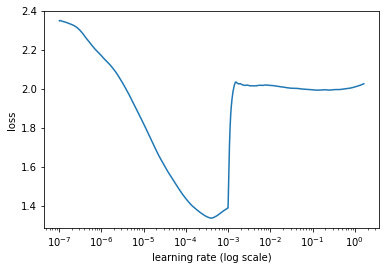

In [68]:
learner.lr_find(show_plot=True, max_epochs=2)

In [69]:
learner.fit_onecycle(5e-5, 4)



begin training using onecycle policy with max lr of 5e-05...
Epoch 1/4
4506/4506 [==============================] - 1471s 323ms/step - loss: 0.6833 - accuracy: 0.7645 - val_loss: 0.3654 - val_accuracy: 0.8675
Epoch 2/4
4506/4506 [==============================] - 1453s 321ms/step - loss: 0.3914 - accuracy: 0.8549 - val_loss: 0.3256 - val_accuracy: 0.8764
Epoch 3/4
4506/4506 [==============================] - 1453s 321ms/step - loss: 0.3116 - accuracy: 0.8822 - val_loss: 0.2553 - val_accuracy: 0.9037
Epoch 4/4
4506/4506 [==============================] - 1453s 321ms/step - loss: 0.1849 - accuracy: 0.9274 - val_loss: 0.2173 - val_accuracy: 0.9268


## STEP 3: Evaluate and Inspect the Model

In [70]:
learner.validate(class_names=t.get_classes())

                 precision    recall  f1-score   support

           ADHD       0.95      0.94      0.94       567
           Acne       0.97      0.97      0.97      1328
        Anxiety       0.89      0.86      0.87      1163
Bipolar Disorde       0.92      0.86      0.89       799
  Birth Control       0.99      0.99      0.99      6670
     Depression       0.87      0.91      0.89      1728
       Insomnia       0.92      0.88      0.90       787
        Obesity       0.76      0.71      0.74       929
           Pain       0.92      0.96      0.94       769
    Weight Loss       0.75      0.77      0.76       977

       accuracy                           0.93     15717
      macro avg       0.89      0.89      0.89     15717
   weighted avg       0.93      0.93      0.93     15717



array([[ 534,    0,    3,    0,    3,   17,    3,    1,    3,    3],
       [   1, 1291,    1,    1,   30,    2,    0,    0,    2,    0],
       [  10,    5, 1004,   11,    4,   97,   18,    0,   13,    1],
       [   6,    0,   15,  690,    5,   72,    5,    3,    2,    1],
       [   0,   30,    1,    1, 6626,    8,    1,    1,    1,    1],
       [   8,    3,   69,   34,    8, 1568,   18,    4,   13,    3],
       [   4,    1,   28,    6,    3,   26,  696,    0,   22,    1],
       [   0,    0,    2,    1,    2,    7,    3,  664,    3,  247],
       [   1,    2,    7,    2,    1,   10,    9,    0,  736,    1],
       [   0,    0,    3,    2,    4,    5,    1,  204,    1,  757]])

Let's examine the validation example about which we were the most wrong.

In [71]:
learner.view_top_losses(n=1, preproc=t)

----------
id:7225 | loss:10.42 | true:Depression | pred:Birth Control)



In [73]:
print(x_test[7225])

It does it's job. I've been on it for 5 years off and on because of pregnancies. I made decision to come off it and its been 1 month and I must admit my mood is low and the dizziness is horrible.


This post talks more about computing than `alt.atheism` (the true category), so our model placed it into the only computing category available to it: `comp.graphics`

## STEP 4: Making Predictions on New Data in Deployment

In [74]:
predictor = ktrain.get_predictor(learner.model, preproc=t)

In [75]:
predictor.predict('I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz.')

'Birth Control'

In [76]:
# predicted probability scores for each category
predictor.predict_proba("I was on this pill for almost two years. It does work as far as not getting pregnant however my experience at first was it didn&#039;t make a huge difference then 6 or 7 months into it my sex drive went down, along with being very very dry, my moodiness increased drastically. I would cry one second and then get angry with my husband over anything and everything. My skin has gotten a lot worse, I broke out in places I never had in the last week. So now I am on Yaz.")

array([2.3475234e-06, 6.6926714e-04, 9.8310056e-06, 5.4652860e-06,
       9.9927920e-01, 1.6659289e-05, 2.3414038e-06, 1.8745473e-06,
       8.9838077e-06, 4.0780906e-06], dtype=float32)

In [77]:
predictor.get_classes()

['ADHD',
 'Acne',
 'Anxiety',
 'Bipolar Disorde',
 'Birth Control',
 'Depression',
 'Insomnia',
 'Obesity',
 'Pain',
 'Weight Loss']

As expected, `Birth Control` is assigned the highest probability.

Let's invoke the `explain` method to see which words contribute most to the classification.

We will need a forked version of the **eli5** library that supportes TensorFlow Keras, so let's install it first.

In [78]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1


In [89]:
diagnosis = predictor.get_classes()

In [100]:
i = 0
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  ADHD


In [101]:
i = 1
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Acne


In [103]:
i = 2
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][1]]
predictor.explain(sentence)

Condition =  Anxiety


In [104]:
i = 3
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Bipolar Disorde


In [105]:
i = 4
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Birth Control


In [106]:
i = 5
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Depression


In [107]:
i = 6
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Insomnia


In [108]:
i = 7
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Obesity


In [109]:
i = 8
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][0]]
predictor.explain(sentence)

Condition =  Pain


In [114]:
i = 9
print("Condition = ", diagnosis[i])
sentence = test['cleanReview'].tolist()[np.where(test['condition'] == diagnosis[i])[0][10]]
predictor.explain(sentence)

Condition =  Weight Loss


In [116]:
predictor.explain("I've been able to focus a lot better on my school work. My grades have improved.")

The words in the darkest shade of green contribute most to the classification and agree with what you would expect for this example.

We can save and reload our predictor for later deployment.

In [80]:
predictor.save('my_distilbert_predictor')

In [81]:
!zip -r saved_keras_model.zip my_distilbert_predictor

  adding: my_distilbert_predictor/ (stored 0%)
  adding: my_distilbert_predictor/config.json (deflated 55%)
  adding: my_distilbert_predictor/tokenizer_config.json (deflated 40%)
  adding: my_distilbert_predictor/vocab.txt (deflated 53%)
  adding: my_distilbert_predictor/tokenizer.json (deflated 59%)
  adding: my_distilbert_predictor/tf_model.preproc (deflated 46%)
  adding: my_distilbert_predictor/tf_model.h5 (deflated 8%)
  adding: my_distilbert_predictor/special_tokens_map.json (deflated 40%)


In [ ]:
from google.colab import files
files.download("saved_keras_model.zip")


In [ ]:
reloaded_predictor = ktrain.load_predictor('/tmp/my_distilbert_predictor')

In [ ]:
reloaded_predictor.predict('My computer monitor is really blurry.')

'comp.graphics'